In [36]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [43]:
def calculate_performance_metrics(x_test, y_test, model):

    # Predictions
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='macro')
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='macro')

    auc = metrics.roc_auc_score(y_test, y_pred, average = 'macro', multi_class = 'ovr')

    print(f"Accuracy: {accuracy}\nAUC: {auc}")
    
    print("\nmacro")
    print(f"Precision: {precision_macro}\nRecall: {recall_macro}\nF1 Score: {f1_macro}")

    print("\nweighted")
    print(f"Precision: {precision_weighted}\nRecall: {recall_weighted}\nF1 Score: {f1_weighted}")
    print()
    
    # Confusion matrix for FNR, TNR, FPR, TPR
    cm = metrics.confusion_matrix(y_test, y_pred_classes)
    def calculate_rates(conf_matrix, class_index):
        tp = conf_matrix[class_index, class_index]
        fn = np.sum(conf_matrix[class_index, :]) - tp
        fp = np.sum(conf_matrix[:, class_index]) - tp
        tn = np.sum(conf_matrix) - (tp + fn + fp)
    
        fnr = fn / (fn + tp)
        tnr = tn / (tn + fp)
        fpr = fp / (fp + tn)
        tpr = tp / (tp + fn)
        return fnr, tnr, fpr, tpr

    # Calculate and aggregate rates
    fnrs, tnrs, fprs, tprs = [], [], [], []
    for i in range(cm.shape[0]):
        fnr, tnr, fpr, tpr = calculate_rates(cm, i)
        fnrs.append(fnr)
        tnrs.append(tnr)
        fprs.append(fpr)
        tprs.append(tpr)
    
    mean_fnr = np.mean(fnrs)
    mean_tnr = np.mean(tnrs)
    mean_fpr = np.mean(fprs)
    mean_tpr = np.mean(tprs)

    # Printing the mean metrics
    print(f"Mean FNR: {mean_fnr}\nMean TNR: {mean_tnr}\nMean FPR: {mean_fpr}\nMean TPR: {mean_tpr}")

In [33]:
def model_plot(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [15]:
x_test = np.load("/home/jovyan/X-IIoT/X-IIoT_preprocessed/x_test.npy")
x_train = np.load("/home/jovyan/X-IIoT/X-IIoT_preprocessed/x_train.npy")
x_val = np.load("/home/jovyan/X-IIoT/X-IIoT_preprocessed/x_val.npy")
y_test = np.load("/home/jovyan/X-IIoT/X-IIoT_preprocessed/y_test.npy")
y_train = np.load("/home/jovyan/X-IIoT/X-IIoT_preprocessed/y_train.npy")
y_val = np.load("/home/jovyan/X-IIoT/X-IIoT_preprocessed/y_val.npy")

In [16]:
x_train

array([[6.66666667e-01, 2.50000000e-01, 1.84336595e-03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [6.66666667e-01, 6.87500000e-01, 2.57195581e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.66666667e-01, 8.75000000e-01, 2.52193550e-04, ...,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       ...,
       [6.66666667e-01, 2.50000000e-01, 5.85182960e-04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.25000000e-01, 2.38977561e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.66666667e-01, 6.87500000e-01, 4.82241715e-09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [17]:
timesteps = 1
features_per_timestep = x_train.shape[1]

x_train_reshaped = x_train.reshape(-1, timesteps, features_per_timestep)
x_val_reshaped = x_val.reshape(-1, timesteps, features_per_timestep)
x_test_reshaped = x_test.reshape(-1, timesteps, features_per_timestep)

num_classes = len(np.unique(y_train))

In [38]:
model = Sequential()
model.add(SimpleRNN(200, activation='relu', input_shape=(timesteps, features_per_timestep)))
model.add(Dropout(0.2))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = num_classes, activation = 'softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train_reshaped, y_train, batch_size=100, epochs=50, validation_split = 0.2,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3)])

Epoch 1/50
3590/3590 [==============================] - 12s 3ms/step - loss: 0.1919 - accuracy: 0.9418 - val_loss: 0.1094 - val_accuracy: 0.9633
Epoch 2/50
3590/3590 [==============================] - 11s 3ms/step - loss: 0.1087 - accuracy: 0.9644 - val_loss: 0.0905 - val_accuracy: 0.9676
Epoch 3/50
3590/3590 [==============================] - 10s 3ms/step - loss: 0.0969 - accuracy: 0.9668 - val_loss: 0.0826 - val_accuracy: 0.9705
Epoch 4/50
3590/3590 [==============================] - 10s 3ms/step - loss: 0.0898 - accuracy: 0.9691 - val_loss: 0.0742 - val_accuracy: 0.9748
Epoch 5/50
3590/3590 [==============================] - 10s 3ms/step - loss: 0.0833 - accuracy: 0.9716 - val_loss: 0.0702 - val_accuracy: 0.9754
Epoch 6/50
3590/3590 [==============================] - 10s 3ms/step - loss: 0.0796 - accuracy: 0.9726 - val_loss: 0.0636 - val_accuracy: 0.9778
Epoch 7/50
3590/3590 [==============================] - 9s 3ms/step - loss: 0.0769 - accuracy: 0.9740 - val_loss: 0.0701 - val_acc

In [44]:
calculate_performance_metrics(x_test_reshaped, y_test, model)

4383/4383 [==============================] - 3s 661us/step
Accuracy: 0.9807031305712044
AUC: 0.9988116684249126

macro
Precision: 0.9673437382145315
Recall: 0.8569211607287169
F1 Score: 0.8874007881645516

weighted
Precision: 0.9673437382145315
Recall: 0.8569211607287169
F1 Score: 0.8874007881645516

Mean FNR: 0.143078839271283
Mean TNR: 0.9978994577482186
Mean FPR: 0.0021005422517813726
Mean TPR: 0.8569211607287169


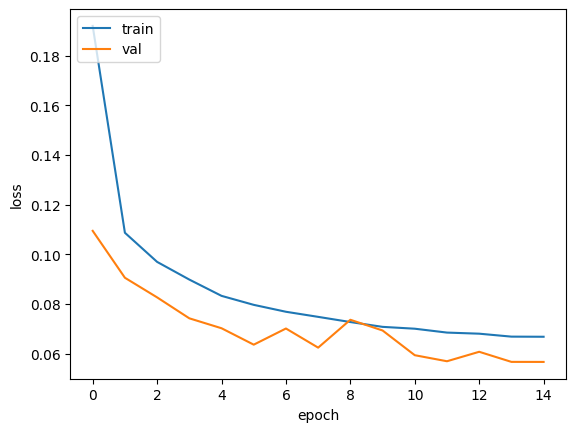

In [40]:
model_plot(history)